In [6]:
!git clone https://github.com/Coeze/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 611, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 611 (delta 119), reused 13 (delta 13), pack-reused 428 (from 4)
Receiving objects: 100% (611/611), 17.62 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (336/336), done.


In [7]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


In [8]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap noise scikit-image

## Import Libraries

Import the necessary Python libraries and custom modules for the fire simulation.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.model import CA

from noise import snoise2
import json

In [10]:
# Load the real Pine Hollow fire data
fire = "arizona"
grid_size = (250,250)


In [11]:
def generate_terrain_simplex(rows, cols, cell_size=30.0, min_elevation=100, max_elevation=1000,
                           octaves=6, persistence=0.5, lacunarity=2.0, scale=100.0, seed=None):
    """
    Generate realistic terrain elevation, slope, and aspect using Simplex noise.

    Parameters:
    - rows, cols: Dimensions of the grid
    - cell_size: size of each cell in meters
    - min_elevation, max_elevation: Range of elevation values in meters
    - octaves: Number of noise layers to combine (more = more detail)
    - persistence: How much each octave contributes (amplitude multiplier)
    - lacunarity: How frequency increases with each octave
    - scale: Base scale of the noise (higher = more gradual changes)
    - seed: Random seed for reproducibility

    Returns:
    - elevation: 2D numpy array of elevation values
    - slope: 2D numpy array of slope values in degrees
    - aspect: 2D numpy array of aspect values in degrees (0-360, 0=North)
    """

    if seed is not None:
        np.random.seed(seed)

    # Generate elevation using simplex noise
    elevation = np.zeros((rows, cols))

    # For better performance, vectorise the coordinates
    y_coords = np.linspace(0, scale, rows)
    x_coords = np.linspace(0, scale, cols)

    for octave in range(octaves):
        frequency = lacunarity ** octave
        amplitude = persistence ** octave

        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                elevation[i, j] += amplitude * snoise2(
                    y * frequency / scale,
                    x * frequency / scale
                )

    # Normalise to 0-1 range
    elevation_min = elevation.min()
    elevation_max = elevation.max()
    elevation = (elevation - elevation_min) / (elevation_max - elevation_min)

    # Scale to desired elevation range
    elevation = min_elevation + elevation * (max_elevation - min_elevation)

    # Calculate slope and aspect from elevation using gradients
    dy, dx = np.gradient(elevation, cell_size, cell_size)

    # Calculate slope in degrees
    # Slope is the angle of steepest descent
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Calculate aspect in degrees (0-360, clockwise from north)
    # Aspect is the direction of steepest descent
    aspect = np.degrees(np.arctan2(-dx, dy))
    # Convert to 0-360 range (0 = North)
    aspect = np.where(aspect < 0, aspect + 360, aspect)

    return elevation, slope, aspect

# Generate terrain using simplex noise instead of random values
elevation, slope, aspect = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=100,
    max_elevation=1000,
    scale=100.0,
    seed=42
)

# Adjust humidity based on elevation (higher elevation = typically lower humidity)
elevation_normalised = (elevation - 100) / 900  # Normalise to 0-1 range

In [12]:
def run_dynamic_environment_simulation(model, steps=30, dt=0.1):
    """Run simulation with stochastic differential equation updates for environmental conditions"""
    history = [np.copy(model.grid)]
    env_history = []

    # Record initial environmental conditions
    env_history.append({
        'wind_speed': model.wind_speed,
        'wind_direction': model.wind_direction,
        'temperature': model.temperature,
        'humidity': np.mean(model.humidity),
        'precipitation': model.precipitation
    })

    for step in range(steps):
        # Update environmental conditions using SDEs
        env_conditions = model.update_environmental_conditions(dt=dt)
        env_history.append(env_conditions)

        # Update fire spread
        model.update()
        history.append(np.copy(model.grid))

        # Check if fire is contained
        if not np.any(model.grid == 1):
            print(f"Fire contained after {step+1} steps")
            break

    return history, env_history

def visualise_environmental_changes(env_history):
    """Visualise how environmental conditions change over time on a single chart"""
    env_df = pd.DataFrame(env_history)

    # Create figure with single chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a second y-axis for wind direction (which has a different scale)
    ax2 = ax.twinx()

    # Plot parameters on primary axis
    ax.plot(env_df['wind_speed'], 'b-', label='Wind Speed (m/s)')
    ax.plot(env_df['temperature'], 'r-', label='Temperature (°F)')
    ax.plot(env_df['humidity'], 'g-', label='Humidity (%)')
    ax.plot(env_df['precipitation'], 'c-', label='Precipitation (mm)')

    # Plot wind direction on secondary axis
    ax2.plot(env_df['wind_direction'], 'k--', label='Wind Direction (degrees)')

    # Set labels and titles
    ax.set_xlabel('Simulation Step')
    ax.set_ylabel('Value')
    ax2.set_ylabel('Wind Direction (degrees)')
    plt.title('Environmental Parameters Evolution Over Time')

    # Add grid
    ax.grid(True, alpha=0.3)

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()


Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Running simulation with stochastic environmental conditions...
Updated environmental conditions:
  Wind speed: 25.16 m/s
  Wind direction: 221.83°
  Temperature: 50.00°F
  humidity: 5.00
  Precipitation: 0.00 mm
 prob: 0.6115, we: 1.0415344926281008e-06, a_prob: 9.687294969276826e-08, tp: 0.3, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.638084607312048, precipitation: 1.0002362599846042, pc: 0.4799111862778719, exceeds_threshold: False
 prob: 0.6115, we: 1.0415344926281008e-06, a_prob: 2.411169618582952e-05, tp: 0.375, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6380846073

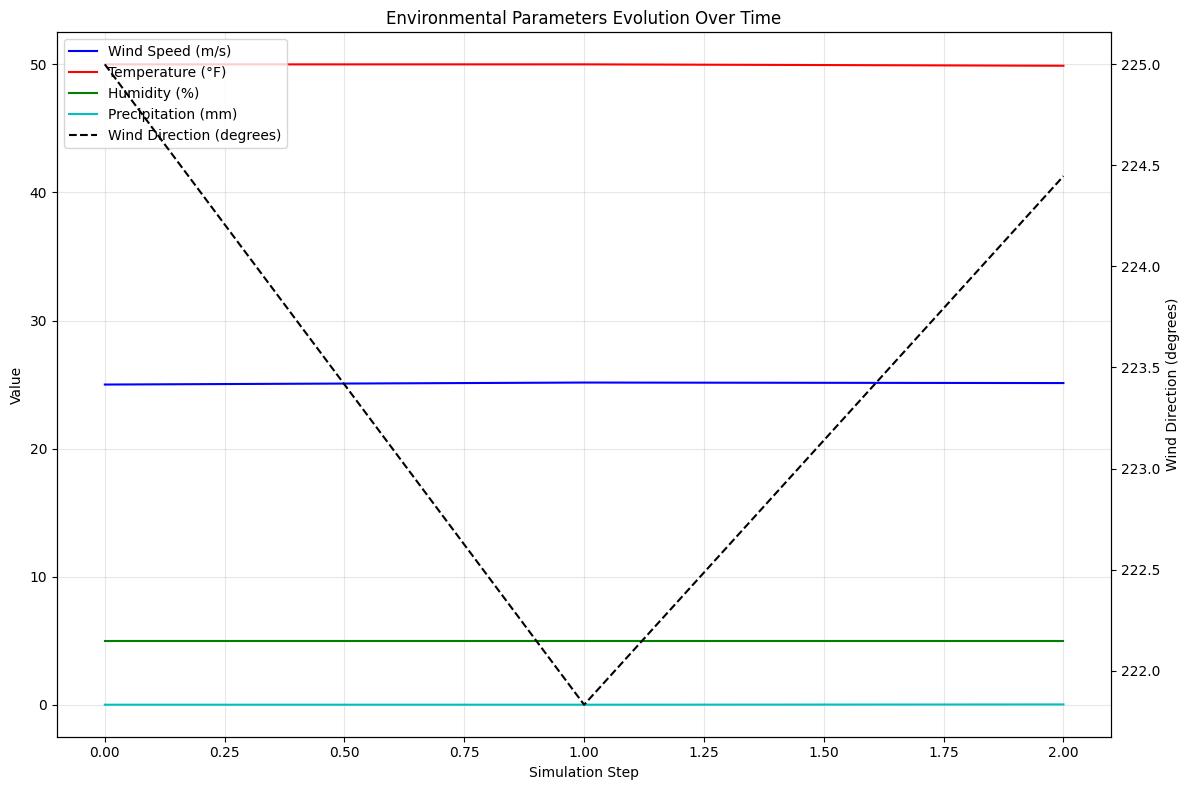

In [20]:
# Initialize model with optimal parameters
optimal_params = {'p0': 0.6115, 'c1': 0.1225, 'c2': 0.3475, 'p1':0.3, 'p2':0.1}

model_sde = CA(grid_size=grid_size, cell_size=1, params=optimal_params)
model_sde.load_mtbs_fire_data(fire)
model_sde.initialise_ndvi_from_data(fire)
model_sde.load_terrain_data(slope, aspect, elevation)

# Set initial environmental conditions
model_sde.set_environmental_data(wind_speed=25.0, wind_direction=225.0,
                            temperature=50, humidity=5, fire_direction=20)

# Run simulation with dynamic environmental conditions
print("Running simulation with stochastic environmental conditions...")
history_sde, env_history = run_dynamic_environment_simulation(model_sde, steps=30, dt=0.1)

# Visualize results
visualise_environmental_changes(env_history)

### 3. Percolation Theory Analysis

Percolation theory provides a more realistic model of fire spread across heterogeneous landscapes by accounting for critical thresholds in fuel connectivity.

In [21]:
def run_advanced_model(fire_folder, params, steps=30, dt=0.1):
    """Run advanced model with all enhanced features"""
    print("Initialising advanced model with all features...")
    model = CA(grid_size=grid_size, cell_size=30, params=params)
    model.load_mtbs_fire_data(fire_folder)
    model.initialise_ndvi_from_data(fire_folder)
    model.load_terrain_data(slope, aspect, elevation)
    model.set_environmental_data(wind_speed=25.0, wind_direction=25.0,
                             temperature=20, humidity=5, fire_direction=20)

    # Run simulation with dynamic environmental conditions
    print("Running advanced simulation...")
    history = [np.copy(model.grid)]
    env_history = []

    # Record initial environmental conditions
    env_history.append({
        'wind_speed': model.wind_speed,
        'wind_direction': model.wind_direction,
        'temperature': model.temperature,
        'humidity': np.mean(model.humidity),
        'precipitation': model.precipitation
    })

    for step in range(steps):
        # Update environmental conditions using SDEs
        env_conditions = model.update_environmental_conditions(dt=dt)
        env_history.append(env_conditions)

        # Update fire spread (with percolation effects already included)
        model.update()
        history.append(np.copy(model.grid))

        # Stop if no more burning cells
        if not np.any(model.grid == 1):
            print(f"Fire contained after {step+1} steps")
            break

    # Visualise final fire spread
    model.visualise_simulation(history)

    if model.actual_burned_area is not None:
        # Compare with actual burn data
        print("\nComparing with actual burn data:")
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  Sørensen Index: {sorensen:.4f}")

        # Show comparison with actual burned area
        fig = model.overlay_simulation_with_actual(fire_folder)
        plt.show()

    return model, history, env_history

Initialising advanced model with all features...
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
Running advanced simulation...
Updated environmental conditions:
  Wind speed: 25.06 m/s
  Wind direction: 23.09°
  Temperature: 20.36°F
  humidity: 5.00
  Precipitation: 0.04 mm
 prob: 0.6115, we: 21.2595666745881, a_prob: 11.385494185401688, tp: 0.35, p_density: 0.8018129615227354, humidity: 2.7680881085078086, temperature: 1.4842650002441855, precipitation: 1.0147965901688696, pc: 0.4576889640556497, exceeds_threshold: True
 prob: 0.6115, we: 21.2595666745881, a_prob: 2679.2780055861035, tp: 0.35, p_density: 0.7952676482798644, humidity: 2.7680881085078086, temperature: 1.484265000244

/content/MX4553_Modelling_Theory_Project/src/model.py:147: RuntimeWarning: overflow encountered in exp
  slope_factor = np.exp((3.533 * (np.tan(slope))))


Streaming output truncated to the last 5000 lines.
 prob: 0.6115, we: 27.08797923060997, a_prob: 0.05365027531417719, tp: 0.475, p_density: 0.7522359890357024, humidity: 3.093871253140076, temperature: 1.445369191558796, precipitation: 1.1709488596258404, pc: 0.49517315277842955, exceeds_threshold: False
 prob: 0.6115, we: 27.08797923060997, a_prob: 5.785893994815094e-09, tp: 0.3, p_density: 0.7556877786036775, humidity: 3.093871253140076, temperature: 1.445369191558796, precipitation: 1.1709488596258404, pc: 0.5034517424181416, exceeds_threshold: False
 prob: 0.6115, we: 27.08797923060997, a_prob: 0.0010512207583570343, tp: 0.475, p_density: 0.7727127795489024, humidity: 3.093871253140076, temperature: 1.445369191558796, precipitation: 1.1709488596258404, pc: 0.4770865078633567, exceeds_threshold: False
 prob: 0.6115, we: 27.08797923060997, a_prob: 0.00017257122551391115, tp: 0.25, p_density: 0.7720511515973829, humidity: 3.093871253140076, temperature: 1.445369191558796, precipitatio


Comparing with actual burn data:
  Accuracy: 0.6271
  Precision: 0.9858
  Recall: 0.2247
  Sørensen Index: 0.3660


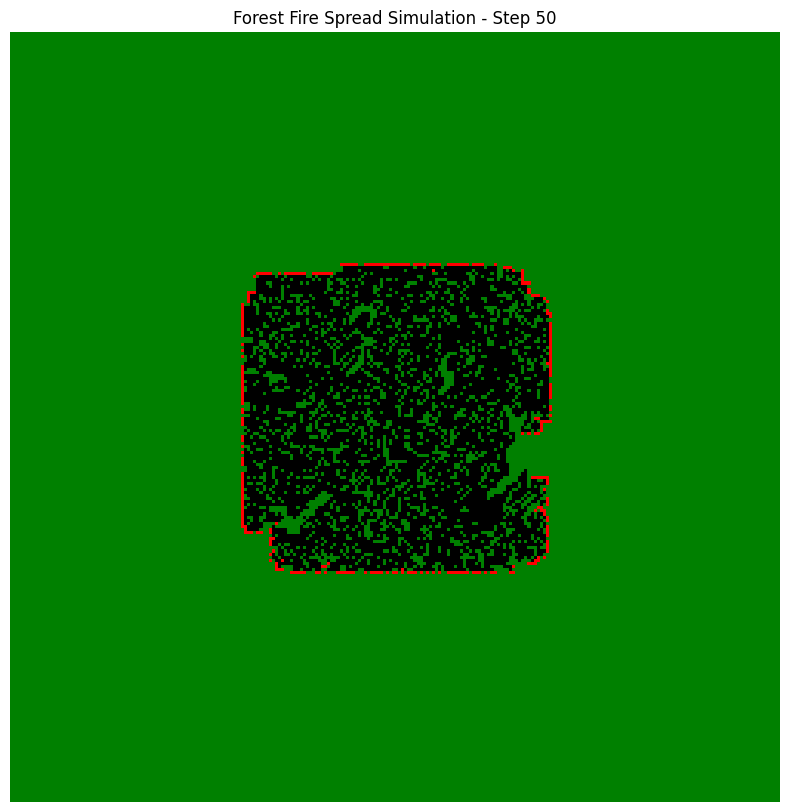

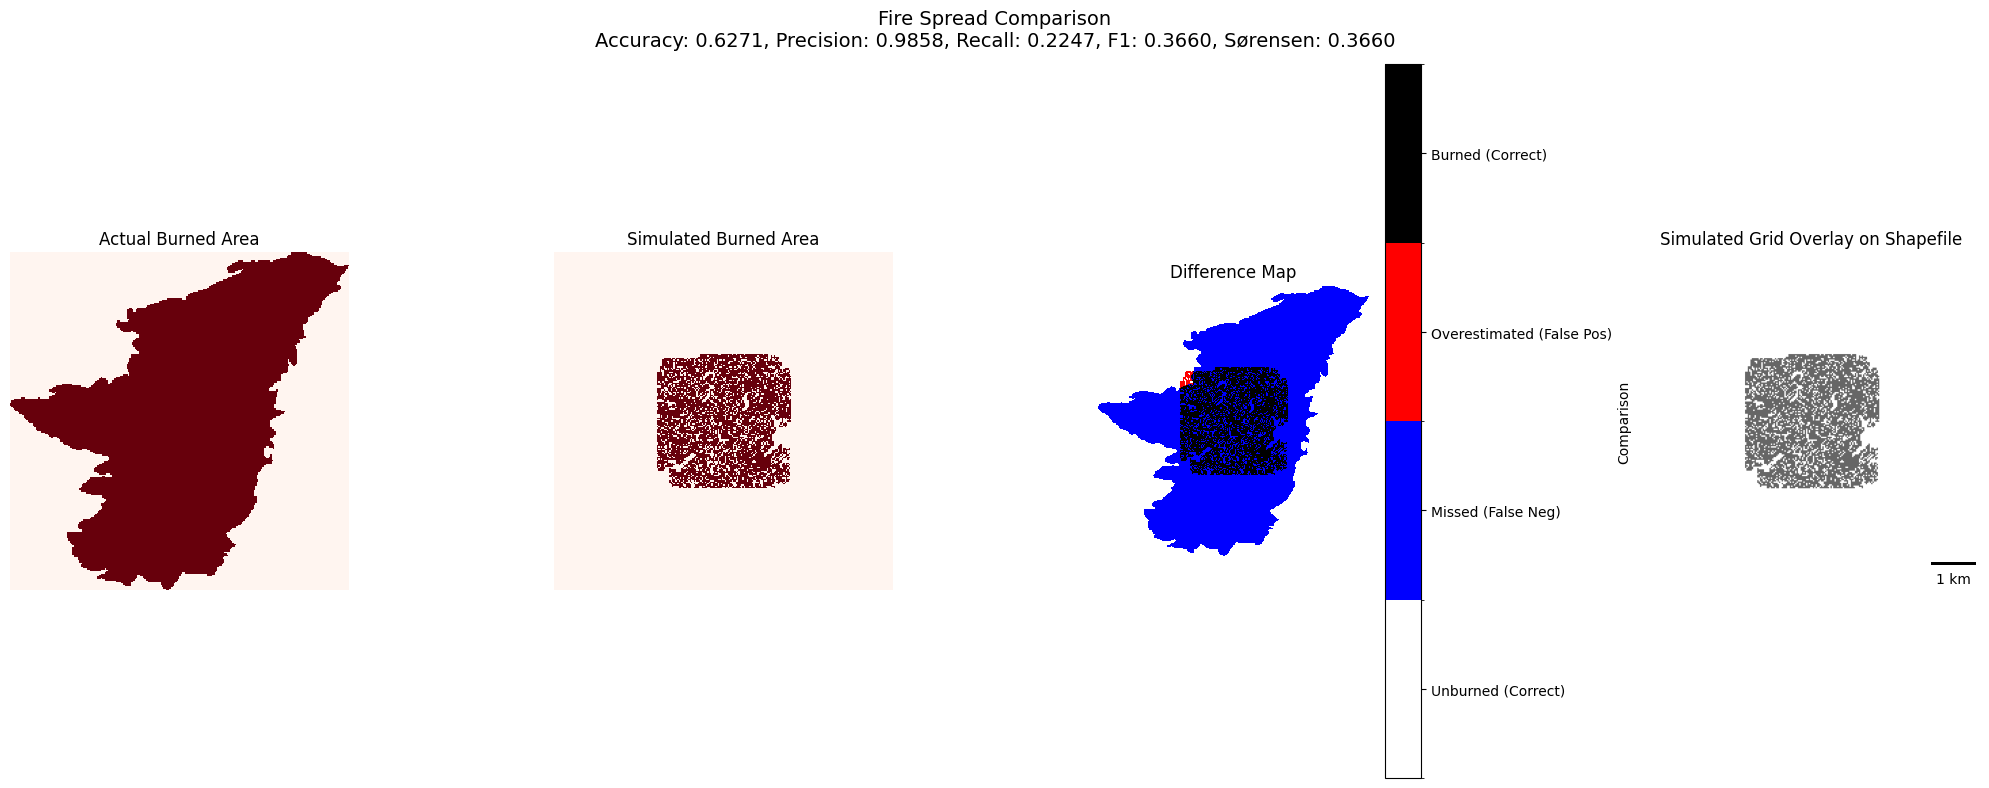

In [22]:
# Run the fully advanced model
advanced_model, advanced_history, advanced_env = run_advanced_model(fire, optimal_params, steps=50, dt=0.1)

In [23]:
from src.interventions import apply_firebreak_strategy, apply_early_detection_strategy, apply_direct_attack_strategy, apply_point_protection_strategy


Evaluating strategy: No Intervention (Baseline)
Description: No firefighting intervention
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.008195230453712342, tp: 0.35, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.4688000751667608, exceeds_threshold: False
 prob: 0.5, we: 0.10375017142416093, a_prob: 18.928193782966684, tp: 0.325, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0, pc: 0.47178525698657936, exceeds_threshold: True
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.00019177904959930442, tp: 

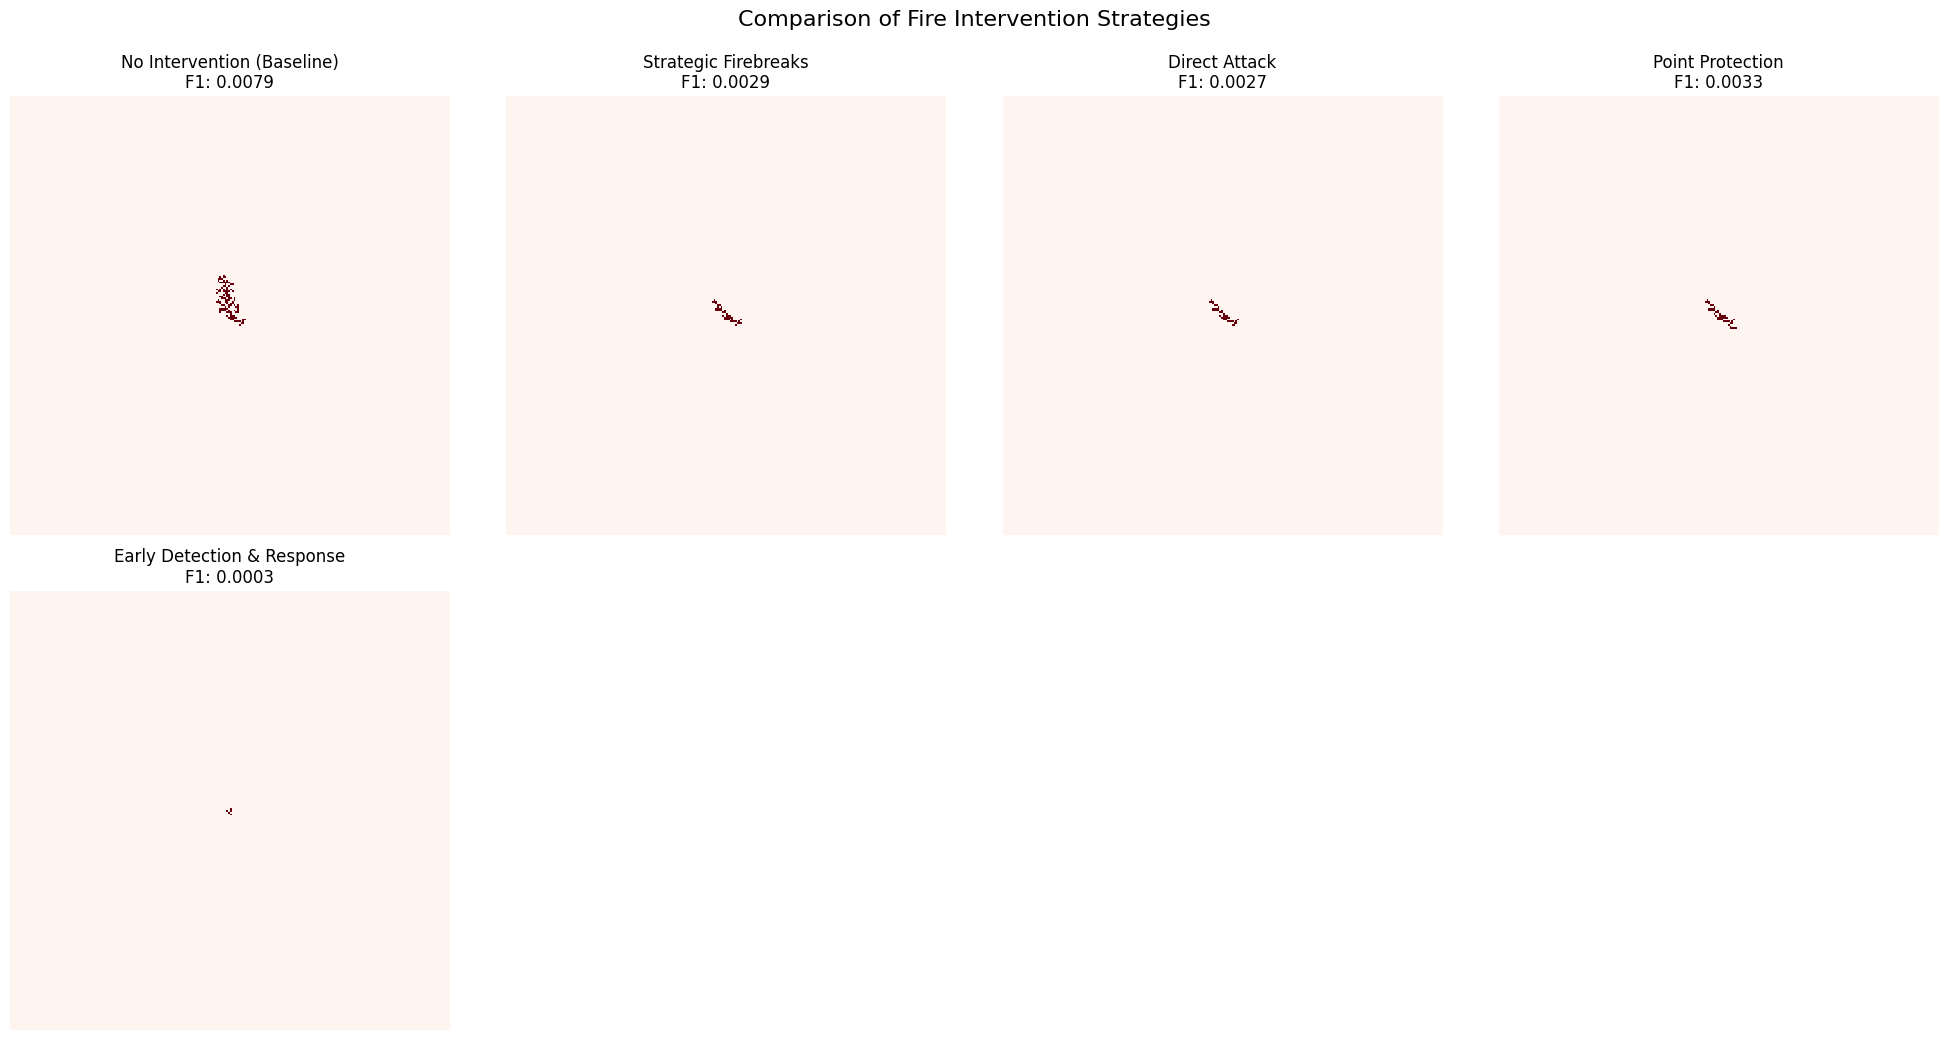

In [24]:
# Define intervention strategies
strategies = {
    'no_intervention': {
        'name': 'No Intervention (Baseline)',
        'description': 'No firefighting intervention',
        'function': lambda model, steps: model.run_simulation(steps)
    },
    'firebreaks': {
        'name': 'Strategic Firebreaks',
        'description': 'Create firebreaks to control fire spread',
        'function': apply_firebreak_strategy
    },
    'direct_attack': {
        'name': 'Direct Attack',
        'description': 'Directly attack the fire front with fire retardant',
        'function': apply_direct_attack_strategy
    },
    'point_protection': {
        'name': 'Point Protection',
        'description': 'Focus resources on protecting specific high-value points',
        'function': apply_point_protection_strategy
    },
    'early_detection': {
        'name': 'Early Detection & Response',
        'description': 'Early detection and rapid initial attack',
        'function': apply_early_detection_strategy
    }
}

# Store results for comparison
results = {}
baseline_result = None

# Create a figure for visualisation of all strategies
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Set the initial fire locations
initial_fire = [(50, 50)]

# Run simulation for each strategy
for i, (strategy_id, strategy) in enumerate(strategies.items()):
    print(f"\nEvaluating strategy: {strategy['name']}")
    print(f"Description: {strategy['description']}")

    # Clone the base model for this strategy
    model = CA(grid_size=grid_size, cell_size=1)
    model.load_mtbs_fire_data(fire)
    model.initialise_ndvi_from_data(fire)
    model.load_terrain_data(slope, aspect, elevation)
    model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50, humidity=5, fire_direction=20)
    # model.set_initial_fire(initial_fire)

    # Apply the strategy and run simulation
    history = strategy['function'](model, 200)

    # Evaluate results
    if model.actual_burned_area is not None:
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Save metrics
        results[strategy_id] = {
            'name': strategy['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'sorensen': sorensen,
            'burned_area': np.sum(model.grid == 2),  # Count of burned cells
            'burnt_grid': (model.grid == 2).astype(int)  # Save the burnt grid for visualisation
        }

        # Save baseline result for comparison
        if strategy_id == 'no_intervention':
            baseline_result = results[strategy_id]

        # Plot results
        ax = axes[i]
        ax.imshow(model.grid == 2, cmap='Reds', interpolation='none')
        ax.set_title(f"{strategy['name']}\nF1: {f1:.4f}")
        ax.axis('off')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Burned Area: {results[strategy_id]['burned_area']} cells")

        # Calculate fire containment percentage if not baseline
        if baseline_result and strategy_id != 'no_intervention':
            containment = 1.0 - (results[strategy_id]['burned_area'] / baseline_result['burned_area'])
            containment_pct = max(0, containment * 100)
            results[strategy_id]['containment_pct'] = containment_pct
            print(f"  Fire Containment: {containment_pct:.1f}%")

# Fill any unused subplot spaces
for i in range(len(strategies), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Comparison of Fire Intervention Strategies", fontsize=16, y=1.02)
plt.show()

<ipython-input-25-718c734846f5>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(strategies, rotation=45, ha='right')
<ipython-input-25-718c734846f5>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strategies, rotation=45, ha='right')


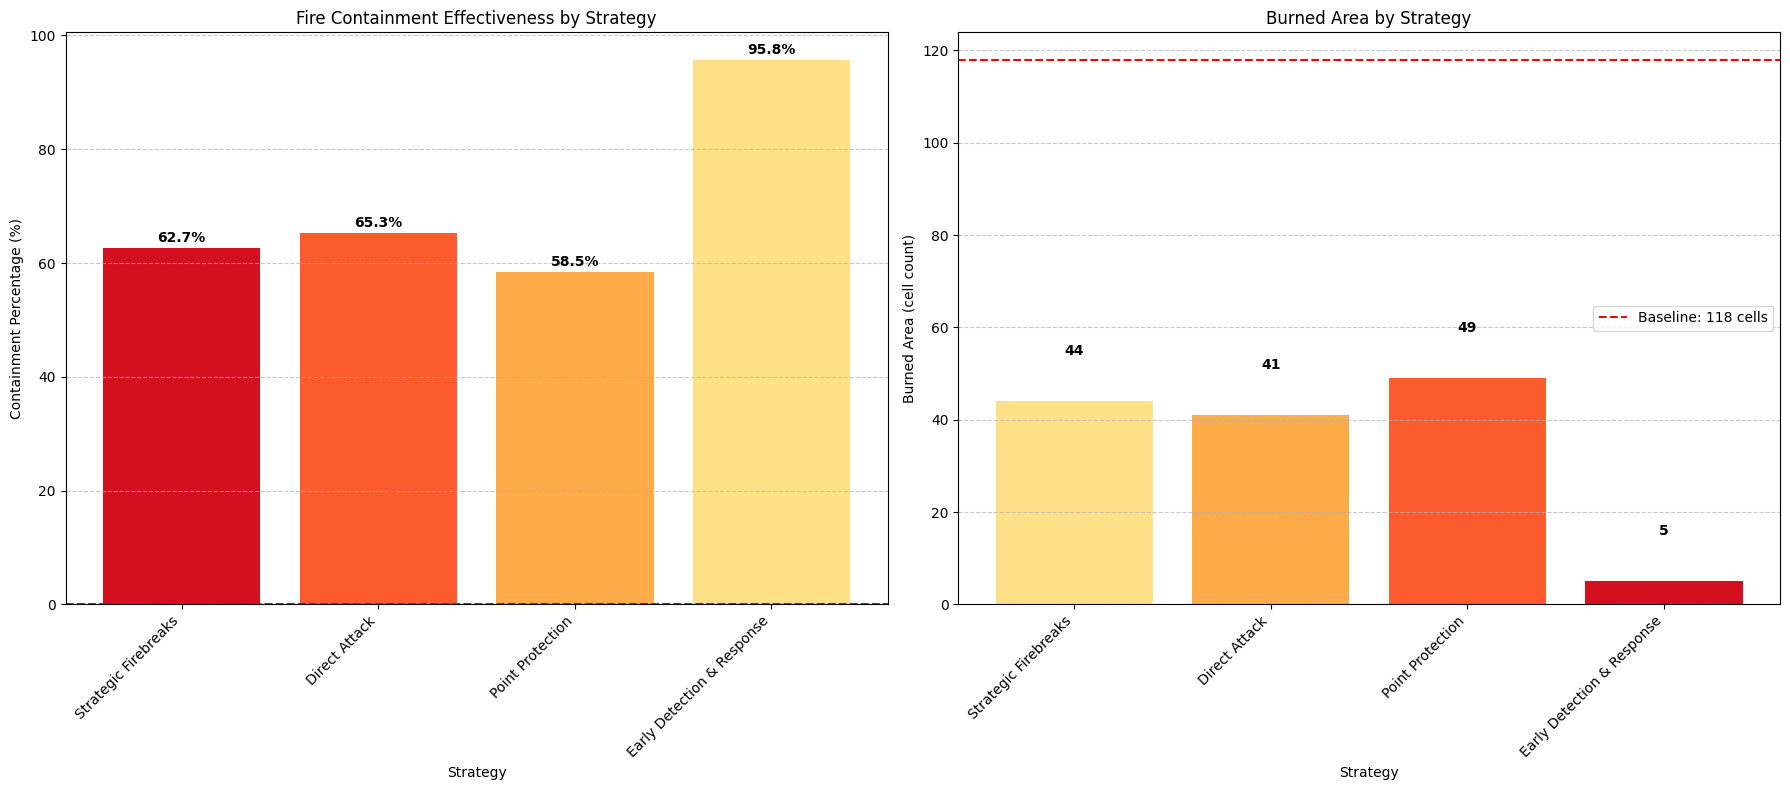

In [25]:
# Extract strategy names and containment percentages
strategies = []
containment_pcts = []
burned_areas = []

for strategy_id, metrics in results.items():
    if strategy_id != 'no_intervention':
        strategies.append(metrics['name'])
        containment_pcts.append(metrics.get('containment_pct', 0))
        burned_areas.append(metrics['burned_area'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot containment percentages
containment_colors = plt.cm.YlOrRd(np.linspace(0.8, 0.2, len(strategies)))
ax1.bar(strategies, containment_pcts, color=containment_colors)
ax1.set_title('Fire Containment Effectiveness by Strategy')
ax1.set_ylabel('Containment Percentage (%)')
ax1.set_xlabel('Strategy')
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
ax1.axhline(y=0, color='r', linestyle='--', label='Baseline (No Intervention)')

# Add labels on bars
for i, v in enumerate(containment_pcts):
    ax1.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# Plot burned areas
burned_colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(strategies)))
ax2.bar(strategies, burned_areas, color=burned_colors)
ax2.set_title('Burned Area by Strategy')
ax2.set_ylabel('Burned Area (cell count)')
ax2.set_xlabel('Strategy')
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
baseline_area = baseline_result['burned_area']
ax2.axhline(y=baseline_area, color='r', linestyle='--', label=f'Baseline: {baseline_area} cells')
ax2.legend()

# Add labels on bars
for i, v in enumerate(burned_areas):
    ax2.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


